In [99]:
import pandas as pd
import jsonpickle
import numpy as np
import matplotlib.pyplot as plt
import os, os.path
import dateutil.parser
import datetime

In [100]:
FILE_AS_ROOT = False
SELF_PATH = os.getcwd()#os.path.dirname(os.path.abspath(__file__))
PATH_TO_ROOT = os.path.join(SELF_PATH,'../')
PATH_TO_JSON_STATES = 'G://Shared drives//P-Sick//data//tagging_json_states'
PATH_TO_JSON_STATES

'G://Shared drives//P-Sick//data//tagging_json_states'

In [101]:
TOTAL_JSON_STATES = (len([name for name in os.listdir(PATH_TO_JSON_STATES) if os.path.isfile(os.path.join(PATH_TO_JSON_STATES, name))]))
print(TOTAL_JSON_STATES)

893


In [102]:
def get_pickle(path_to_file):
    with open(path_to_file, 'r') as f:
        return jsonpickle.decode(f.read())

In [103]:
def how_many_tagged(pickle_file):
    
    done_tagging_count=len(pickle_file.finished_tagged_queue)
    tagged_but_not_done_count=0
    
    for image in pickle_file.pending_images_queue:
        if len(image.get_taggers()) > 0:
            tagged_but_not_done_count-=-1
    
    return pd.DataFrame([{ 
        'not_done':tagged_but_not_done_count,
        'done':done_tagging_count,
        'tagged_ratio': tagged_but_not_done_count/(tagged_but_not_done_count+done_tagging_count),
        'skipped':len(pickle_file.max_skipped_queue),
        'current':len(pickle_file.current_image),
        'tagged_ratio': tagged_but_not_done_count/(tagged_but_not_done_count+done_tagging_count+len(pickle_file.max_skipped_queue)+len(pickle_file.current_image))
     }])

In [104]:
def get_all_json_states(path_states):
    files = os.listdir(path_states)
    filter_by_type = [f for f in files if f[-4:] == 'json']
    filter_by_type.sort()
    return filter_by_type

In [105]:
files_json = get_all_json_states(PATH_TO_JSON_STATES)
print(files_json[1:4])

['assigner_state-root-2019-11-11T20 16 17.207157.json', 'assigner_state-root-2019-11-11T20 16 48.444302.json', 'assigner_state-root-2019-11-11T20 16 51.151759.json']


In [106]:
def get_tagged_ratio(files , skip=50):
    
    main_df = pd.DataFrame()
    
    for file in files[::skip]:
        path = f"{PATH_TO_JSON_STATES}/{file}"
        
        remove_name = file.split('assigner_state-root-')[-1]
        date_string = remove_name.split('.json')[0]
        # print(dateutil.parser.parse(removed_nano))
        date_object = datetime.datetime.strptime(date_string, '%Y-%m-%dT%H %M %S.%f')
        time = date_object.timestamp()
        # time = dateutil.parser.parse(removed_nano).strftime('%s')
        time_df= pd.DataFrame([{'time':time,'name':date_string, 'date-time':date_object.time()}])    

        tag_df = how_many_tagged(get_pickle(path))
        
        combined_df = pd.concat([time_df,tag_df],axis=1, sort=False)
        main_df = pd.concat([combined_df,main_df],ignore_index=True)
        
    return main_df

In [107]:
df = get_tagged_ratio(files_json)
df_time_sort = df.sort_values(by=['time'])

In [108]:
df_time_sort.head()

,time,name,date-time,not_done,done,tagged_ratio,skipped,current
17,1.573465e+09,2019-11-10T23 30 48.430349,23:30:48.430349,237,0,0.995798,0,1
16,1.573540e+09,2019-11-11T20 33 38.520814,20:33:38.520814,216,20,0.907563,0,2
15,1.573577e+09,2019-11-12T06 39 45.766386,06:39:45.766386,195,40,0.819328,0,3
14,1.573577e+09,2019-11-12T06 48 55.595966,06:48:55.595966,175,61,0.732218,0,3
13,1.573607e+09,2019-11-12T15 10 50.669186,15:10:50.669186,158,79,0.658333,0,3


In [109]:
df_time_sort[['tagged_ratio','time','date-time']].head()

,tagged_ratio,time,date-time
17,0.995798,1.573465e+09,23:30:48.430349
16,0.907563,1.573540e+09,20:33:38.520814
15,0.819328,1.573577e+09,06:39:45.766386
14,0.732218,1.573577e+09,06:48:55.595966
13,0.658333,1.573607e+09,15:10:50.669186


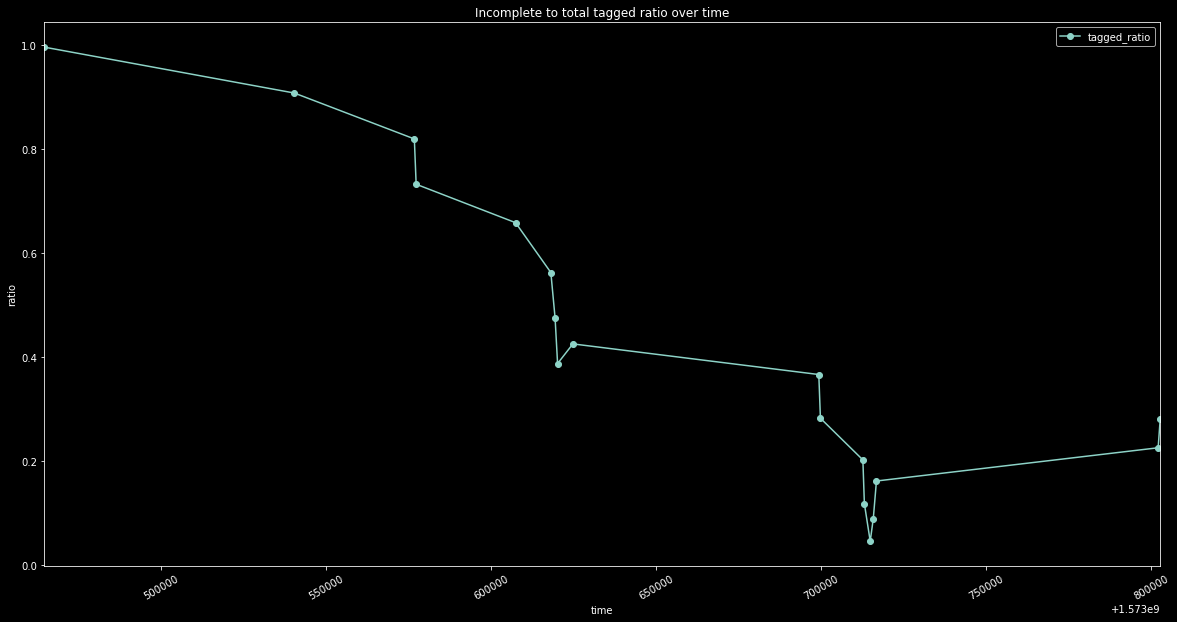

In [121]:
(df_time_sort[['tagged_ratio','time','date-time']]).plot(x='time', y='tagged_ratio', marker='o',rot=30,figsize=(20, 10))

plt.style.use('dark_background')

plt.xlabel('time')
plt.ylabel('ratio')

plt.style.use('dark_background')

plt.title("Incomplete to total tagged ratio over time")

plt.legend()
plt.show()